In [1]:
# Required headers
import os
import gzip
import numpy
import matplotlib.pyplot as plt

# TensorFlow
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets import base
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import random_seed
from tensorflow.python.platform import gfile

In [2]:
# CVDF mirror of http://yann.lecun.com/exdb/mnist/
SOURCE_URL = 'https://storage.googleapis.com/cvdf-datasets/mnist/'

# MNIST filenames.
TRAIN_IMAGES = 'train-images-idx3-ubyte.gz'
TRAIN_LABELS = 'train-labels-idx1-ubyte.gz'
TEST_IMAGES = 't10k-images-idx3-ubyte.gz'
TEST_LABELS = 't10k-labels-idx1-ubyte.gz'

# Local dir where MNIST files will be stored.
MNIST_DIR = '/home/tkornuta/tensorflow/data/mnist/'

### Helper functions for extracting MNIST images.

In [3]:
def _read32(bytestream):
  dt = numpy.dtype(numpy.uint32).newbyteorder('>')
  return numpy.frombuffer(bytestream.read(4), dtype=dt)[0]

def extract_images(f):
  """Extract the images into a 4D uint8 numpy array [index, y, x, depth].
  Args:
    f: A file object that can be passed into a gzip reader.
  Returns:
    data: A 4D uint8 numpy array [index, y, x, depth].
  Raises:
    ValueError: If the bytestream does not start with 2051.
  """
  print('Extracting', f.name)
  with gzip.GzipFile(fileobj=f) as bytestream:
    magic = _read32(bytestream)
    if magic != 2051:
      raise ValueError('Invalid magic number %d in MNIST image file: %s' %
                       (magic, f.name))
    num_images = _read32(bytestream)
    rows = _read32(bytestream)
    cols = _read32(bytestream)
    buf = bytestream.read(rows * cols * num_images)
    data = numpy.frombuffer(buf, dtype=numpy.uint8)
    data = data.reshape(num_images, rows, cols, 1)
    print('Loaded', data.shape[0], 'images')
    return data


### Helper functions for extracting MNIST labels.

In [4]:
def dense_to_one_hot(labels_dense, num_classes):
  """Convert class labels from scalars to one-hot vectors."""
  num_labels = labels_dense.shape[0]
  index_offset = numpy.arange(num_labels) * num_classes
  labels_one_hot = numpy.zeros((num_labels, num_classes))
  labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
  return labels_one_hot


def extract_labels(f, one_hot=False, num_classes=10):
  """Extract the labels into a 1D uint8 numpy array [index].
  Args:
    f: A file object that can be passed into a gzip reader.
    one_hot: Does one hot encoding for the result.
    num_classes: Number of classes for the one hot encoding.
  Returns:
    labels: a 1D uint8 numpy array.
  Raises:
    ValueError: If the bystream doesn't start with 2049.
  """
  print('Extracting', f.name)
  with gzip.GzipFile(fileobj=f) as bytestream:
    magic = _read32(bytestream)
    if magic != 2049:
      raise ValueError('Invalid magic number %d in MNIST label file: %s' %
                       (magic, f.name))
    num_items = _read32(bytestream)
    buf = bytestream.read(num_items)
    labels = numpy.frombuffer(buf, dtype=numpy.uint8)
    if one_hot:
      return dense_to_one_hot(labels, num_classes)
  return labels

### Create helper DataSet class

In [5]:
class DataSet(object):

  def __init__(self,
               images,
               labels,
               fake_data=False,
               one_hot=False,
               dtype=dtypes.float32,
               reshape=True,
               seed=None):
    """Construct a DataSet.
    one_hot arg is used only if fake_data is true.  `dtype` can be either
    `uint8` to leave the input as `[0, 255]`, or `float32` to rescale into
    `[0, 1]`.  Seed arg provides for convenient deterministic testing.
    """
    seed1, seed2 = random_seed.get_seed(seed)
    # If op level seed is not set, use whatever graph level seed is returned
    numpy.random.seed(seed1 if seed is None else seed2)
    dtype = dtypes.as_dtype(dtype).base_dtype
    if dtype not in (dtypes.uint8, dtypes.float32):
      raise TypeError('Invalid image dtype %r, expected uint8 or float32' %
                      dtype)
    if fake_data:
      self._num_examples = 10000
      self.one_hot = one_hot
    else:
      assert images.shape[0] == labels.shape[0], (
          'images.shape: %s labels.shape: %s' % (images.shape, labels.shape))
      self._num_examples = images.shape[0]

      # Convert shape from [num examples, rows, columns, depth]
      # to [num examples, rows*columns] (assuming depth == 1)
      if reshape:
        assert images.shape[3] == 1
        #images = images.reshape(images.shape[0], images.shape[1] * images.shape[2])
      if dtype == dtypes.float32:
        # Convert from [0, 255] -> [0.0, 1.0].
        images = images.astype(numpy.float32)
        images = numpy.multiply(images, 1.0 / 255.0)
    self._images = images
    self._labels = labels
    self._epochs_completed = 0
    self._index_in_epoch = 0

  @property
  def images(self):
    return self._images

  @property
  def labels(self):
    return self._labels

  @property
  def num_examples(self):
    return self._num_examples

  @property
  def epochs_completed(self):
    return self._epochs_completed

  def next_batch(self, batch_size, shuffle=True):
    """Return the next `batch_size` examples from this data set."""
    start = self._index_in_epoch
    # Shuffle for the first epoch
    if self._epochs_completed == 0 and start == 0 and shuffle:
      perm0 = numpy.arange(self._num_examples)
      numpy.random.shuffle(perm0)
      self._images = self.images[perm0]
      self._labels = self.labels[perm0]
    # Go to the next epoch
    if start + batch_size > self._num_examples:
      # Finished epoch
      self._epochs_completed += 1
      # Get the rest examples in this epoch
      rest_num_examples = self._num_examples - start
      images_rest_part = self._images[start:self._num_examples]
      labels_rest_part = self._labels[start:self._num_examples]
      # Shuffle the data
      if shuffle:
        perm = numpy.arange(self._num_examples)
        numpy.random.shuffle(perm)
        self._images = self.images[perm]
        self._labels = self.labels[perm]
      # Start next epoch
      start = 0
      self._index_in_epoch = batch_size - rest_num_examples
      end = self._index_in_epoch
      images_new_part = self._images[start:end]
      labels_new_part = self._labels[start:end]
      return numpy.concatenate((images_rest_part, images_new_part), axis=0) , numpy.concatenate((labels_rest_part, labels_new_part), axis=0)
    else:
      self._index_in_epoch += batch_size
      end = self._index_in_epoch
      return self._images[start:end], self._labels[start:end]


### Function for loadind MNIST dataset.

In [6]:
def read_mnist(validation_size=5000):
    
  # Eventually download and extract files containing train/test images and labels.
  local_file = base.maybe_download(TRAIN_IMAGES, MNIST_DIR, SOURCE_URL + TRAIN_IMAGES)
  with gfile.Open(local_file, 'rb') as f:
    train_images = extract_images(f)

  local_file = base.maybe_download(TRAIN_LABELS, MNIST_DIR, SOURCE_URL + TRAIN_LABELS)
  with gfile.Open(local_file, 'rb') as f:
    train_labels = extract_labels(f, one_hot=False)

  local_file = base.maybe_download(TEST_IMAGES, MNIST_DIR, SOURCE_URL + TEST_IMAGES)
  with gfile.Open(local_file, 'rb') as f:
    test_images = extract_images(f)

  local_file = base.maybe_download(TEST_LABELS, MNIST_DIR, SOURCE_URL + TEST_LABELS)
  with gfile.Open(local_file, 'rb') as f:
    test_labels = extract_labels(f, one_hot=False)
    
  # Divide train into two datasets: train and validation.
  if not 0 <= validation_size <= len(train_images):
    raise ValueError(
        'Validation size should be between 0 and {}. Received: {}.'
        .format(len(train_images), validation_size))
  
  validation_images = train_images[:validation_size]
  validation_labels = train_labels[:validation_size]
  train_images = train_images[validation_size:]
  train_labels = train_labels[validation_size:]

  # Set options.
  options = dict(dtype=dtypes.float32, reshape=True, seed=None)
  
  train = DataSet(train_images, train_labels, **options)
  validation = DataSet(validation_images, validation_labels, **options)
  test = DataSet(test_images, test_labels, **options)

  return base.Datasets(train=train, validation=validation, test=test)

### Import dataset

Extracting /home/tkornuta/tensorflow/data/mnist/train-images-idx3-ubyte.gz
Loaded 60000 images
Extracting /home/tkornuta/tensorflow/data/mnist/train-labels-idx1-ubyte.gz
Extracting /home/tkornuta/tensorflow/data/mnist/t10k-images-idx3-ubyte.gz
Loaded 10000 images
Extracting /home/tkornuta/tensorflow/data/mnist/t10k-labels-idx1-ubyte.gz
Image shape: (28, 28, 1)


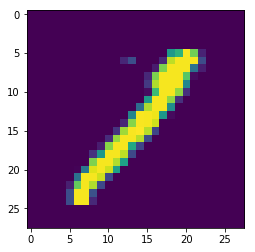

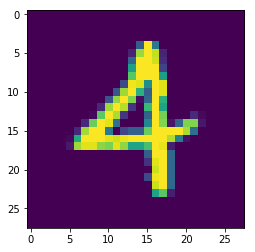

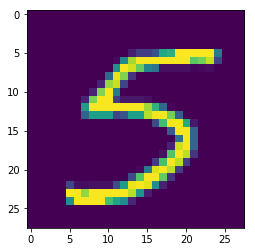

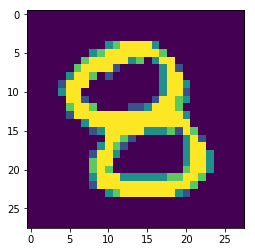

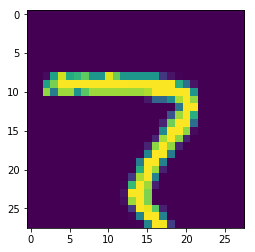

In [7]:
mnist = read_mnist()

BATCH_SIZE = 5

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    # Get image
    images,labels = mnist.train.next_batch(BATCH_SIZE)
    print('Image shape:',images[0].shape)
    # Display images.
    for i in range(BATCH_SIZE):
      plt.imshow(images[i].reshape(28,28), cmap="viridis")
      plt.show()


### Convert datasets to TF record files.

In [8]:
def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def convert_to_tfrecord(data_set, name):
  """Converts a dataset to tfrecords."""
  images = data_set.images
  labels = data_set.labels
  num_examples = data_set.num_examples

  if images.shape[0] != num_examples:
    raise ValueError('Images size %d does not match label size %d.' %
                     (images.shape[0], num_examples))
  rows = images.shape[1]
  cols = images.shape[2]
  depth = images.shape[3]

  filename = os.path.join(MNIST_DIR, name + '.tfrecords')
  print('Writing', filename)
  writer = tf.python_io.TFRecordWriter(filename)
  for index in range(num_examples):
    image_raw = images[index].tostring()
    example = tf.train.Example(features=tf.train.Features(feature={
        'height': _int64_feature(rows),
        'width': _int64_feature(cols),
        'depth': _int64_feature(depth),
        'label': _int64_feature(int(labels[index])),
        'image_raw': _bytes_feature(image_raw)}))
    writer.write(example.SerializeToString())
  writer.close()


In [9]:
  # Convert MNIST to TFRecords.
  convert_to_tfrecord(mnist.train, 'train')
  convert_to_tfrecord(mnist.validation, 'validation')
  convert_to_tfrecord(mnist.test, 'test')


Writing /home/tkornuta/tensorflow/data/mnist/train.tfrecords
Writing /home/tkornuta/tensorflow/data/mnist/validation.tfrecords
Writing /home/tkornuta/tensorflow/data/mnist/test.tfrecords


### Load TFRecord file

In [28]:
def read_and_decode(filename_queue):
  reader = tf.TFRecordReader()
  _, serialized_example = reader.read(filename_queue)
  features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since all keys are required.
      features={
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64),
        'depth': tf.FixedLenFeature([], tf.int64),
        'label': tf.FixedLenFeature([], tf.int64),
        'image_raw': tf.FixedLenFeature([], tf.string),
      })

  # Convert from a scalar string tensor to a uint8 tensor with desired shape.
  image = tf.decode_raw(features['image_raw'], tf.uint8)
  image.set_shape([features['height'], features['width'], features['depth']])

  # OPTIONAL: Could reshape into a 28x28 image and apply distortions
  # here.  Since we are not applying any distortions in this
  # example, and the next step expects the image to be flattened
  # into a vector, we don't bother.

  # Convert from [0, 255] -> [-0.5, 0.5] floats.
  #image = tf.cast(image, tf.float32) * (1. / 255) - 0.5

  # Convert label from a scalar uint8 tensor to an int32 scalar.
  label = tf.cast(features['label'], tf.int32)

  return image, label
